# Deep Learning Playground

This notebook demonstrates:
1. **MLP** for tabular data
2. **CNN** for image data
3. **Simple RNN**, **LSTM**, and **GRU** for sequence data

Feel free to adjust hyper‑parameters and architectures to deepen your understanding!

In [35]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, tensorflow as tf
from tensorflow.keras import layers, models, datasets
import requests
import io
import gzip
import ssl
import certifi
import urllib.request

# Fix SSL permanent
ssl_context = ssl.create_default_context(cafile=certifi.where())
original_urlopen = urllib.request.urlopen

def patched_urlopen(url, data=None, timeout=None, **kwargs):
    if 'context' not in kwargs:
        kwargs['context'] = ssl_context
    return original_urlopen(url, data, timeout, **kwargs)

urllib.request.urlopen = patched_urlopen

print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.19.0


## Part 1 – MLP on Titanic

In [4]:
url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
response = requests.get(url)
data = response.content

titanic = pd.read_csv(io.StringIO(data.decode('utf-8')))
titanic = titanic.drop(['Cabin','Ticket','Name','Embarked'], axis=1)
titanic['Age'].fillna(titanic['Age'].median(), inplace=True)
titanic['Sex'] = titanic['Sex'].map({'male':0,'female':1})
titanic.dropna(inplace=True)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X = titanic[['Pclass','Sex','Age','Fare']].values
y = titanic['Survived'].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [5]:
mlp = models.Sequential([layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
                          layers.Dense(16, activation='relu'),
                          layers.Dense(1, activation='sigmoid')])
mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
mlp.summary()

/Users/chloegerardin/Code/pythonProject/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 705 (2.75 KB)

 Trainable params: 705 (2.75 KB)

 Non-trainable params: 0 (0.00 B)

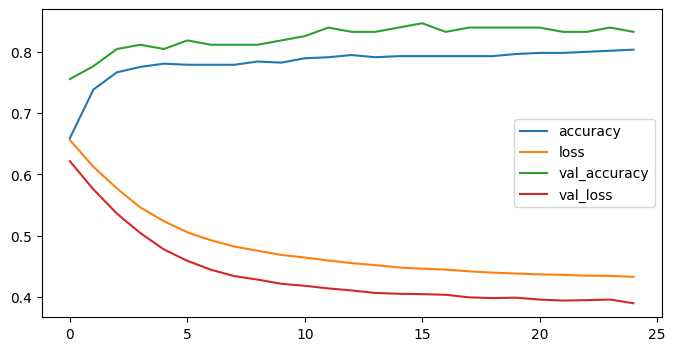

Test accuracy: 0.7932960987091064


In [6]:
hist = mlp.fit(X_train, y_train, epochs=25, batch_size=32,
                    validation_split=0.2, verbose=0)
pd.DataFrame(hist.history).plot(figsize=(8,4)); plt.show()
print('Test accuracy:', mlp.evaluate(X_test, y_test, verbose=0)[1])

## Part 2 – CNN on MNIST

In [40]:
(X_train_m, y_train_m), (X_test_m, y_test_m) = datasets.mnist.load_data()

X_train_m = X_train_m.astype('float32')/255.
X_test_m = X_test_m.astype('float32')/255.
X_train_m = X_train_m[...,None]
X_test_m = X_test_m[...,None]

In [41]:
cnn = models.Sequential([
    layers.Conv2D(32,(3,3),activation='relu',input_shape=(28,28,1)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(10,activation='softmax')
])
cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn.summary()

/Users/chloegerardin/Code/pythonProject/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
cnn.fit(X_train_m, y_train_m, epochs=5, batch_size=128,
        validation_split=0.1, verbose=2)
print('Test accuracy:', cnn.evaluate(X_test_m, y_test_m, verbose=0)[1])

Epoch 1/5
422/422 - 8s - 18ms/step - accuracy: 0.9396 - loss: 0.2151 - val_accuracy: 0.9790 - val_loss: 0.0682
Epoch 2/5
422/422 - 7s - 17ms/step - accuracy: 0.9811 - loss: 0.0619 - val_accuracy: 0.9860 - val_loss: 0.0477
Epoch 3/5
422/422 - 8s - 18ms/step - accuracy: 0.9875 - loss: 0.0403 - val_accuracy: 0.9890 - val_loss: 0.0396
Epoch 4/5
422/422 - 8s - 20ms/step - accuracy: 0.9896 - loss: 0.0330 - val_accuracy: 0.9892 - val_loss: 0.0381
Epoch 5/5
422/422 - 8s - 19ms/step - accuracy: 0.9919 - loss: 0.0251 - val_accuracy: 0.9895 - val_loss: 0.0373
Test accuracy: 0.9900000095367432


## Part 3 – RNNs for Time Series

We'll forecast a sine wave using previous 50 time‑steps.

In [6]:
t = np.linspace(0, 100, 10000)
series = np.sin(t)
window=50
X_seq, y_seq = [], []
for i in range(len(series)-window):
    X_seq.append(series[i:i+window])
    y_seq.append(series[i+window])
X_seq, y_seq = np.array(X_seq)[...,None], np.array(y_seq)
split=int(0.8*len(X_seq))
X_train_s, X_test_s = X_seq[:split], X_seq[split:]
y_train_s, y_test_s = y_seq[:split], y_seq[split:]
print(X_train_s.shape)

(7960, 50, 1)


### Simple RNN

In [7]:
rnn = models.Sequential([layers.SimpleRNN(32, input_shape=(window,1)),
                        layers.Dense(1)])
rnn.compile(optimizer='adam', loss='mse')
rnn.summary()
rnn.fit(X_train_s, y_train_s, epochs=5, batch_size=128, validation_split=0.1, verbose=2)
print('RNN Test MSE:', rnn.evaluate(X_test_s, y_test_s, verbose=0))

/Users/chloegerardin/Code/pythonProject/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 32)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,121 (4.38 KB)

 Trainable params: 1,121 (4.38 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
56/56 - 1s - 17ms/step - loss: 0.0035 - val_loss: 4.2721e-04
Epoch 2/5
56/56 - 0s - 5ms/step - loss: 3.3216e-04 - val_loss: 2.6214e-04
Epoch 3/5
56/56 - 0s - 5ms/step - loss: 2.0960e-04 - val_loss: 1.6171e-04
Epoch 4/5
56/56 - 0s - 5ms/step - loss: 1.2341e-04 - val_loss: 9.3735e-05
Epoch 5/5
56/56 - 0s - 4ms/step - loss: 6.6203e-05 - val_loss: 4.7296e-05
RNN Test MSE: 4.770639498019591e-05


### LSTM

In [8]:
lstm = models.Sequential([layers.LSTM(64, input_shape=(window,1)),
                         layers.Dense(1)])
lstm.compile(optimizer='adam', loss='mse')
lstm.summary()
lstm.fit(X_train_s, y_train_s, epochs=5, batch_size=128, validation_split=0.1, verbose=2)
print('LSTM Test MSE:', lstm.evaluate(X_test_s, y_test_s, verbose=0))

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
56/56 - 4s - 68ms/step - loss: 0.0629 - val_loss: 0.0025
Epoch 2/5
56/56 - 3s - 48ms/step - loss: 0.0020 - val_loss: 0.0014
Epoch 3/5
56/56 - 3s - 50ms/step - loss: 0.0011 - val_loss: 7.7545e-04
Epoch 4/5
56/56 - 2s - 44ms/step - loss: 5.2294e-04 - val_loss: 3.3726e-04
Epoch 5/5
56/56 - 3s - 50ms/step - loss: 1.7687e-04 - val_loss: 8.6576e-05
LSTM Test MSE: 7.531124720117077e-05


### GRU

In [9]:
gru = models.Sequential([layers.GRU(64, input_shape=(window,1)),
                        layers.Dense(1)])
gru.compile(optimizer='adam', loss='mse')
gru.summary()
gru.fit(X_train_s, y_train_s, epochs=5, batch_size=128, validation_split=0.1, verbose=2)
print('GRU Test MSE:', gru.evaluate(X_test_s, y_test_s, verbose=0))

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 64)             │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,929 (50.50 KB)

 Trainable params: 12,929 (50.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
56/56 - 4s - 77ms/step - loss: 0.1633 - val_loss: 0.0032
Epoch 2/5
56/56 - 2s - 43ms/step - loss: 9.3150e-04 - val_loss: 6.0800e-04
Epoch 3/5
56/56 - 3s - 51ms/step - loss: 6.0305e-04 - val_loss: 5.4826e-04
Epoch 4/5
56/56 - 3s - 47ms/step - loss: 5.3833e-04 - val_loss: 4.9216e-04
Epoch 5/5
56/56 - 3s - 47ms/step - loss: 4.8540e-04 - val_loss: 4.5749e-04
GRU Test MSE: 0.00045237925951369107


## Visualizing MNIST Data

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


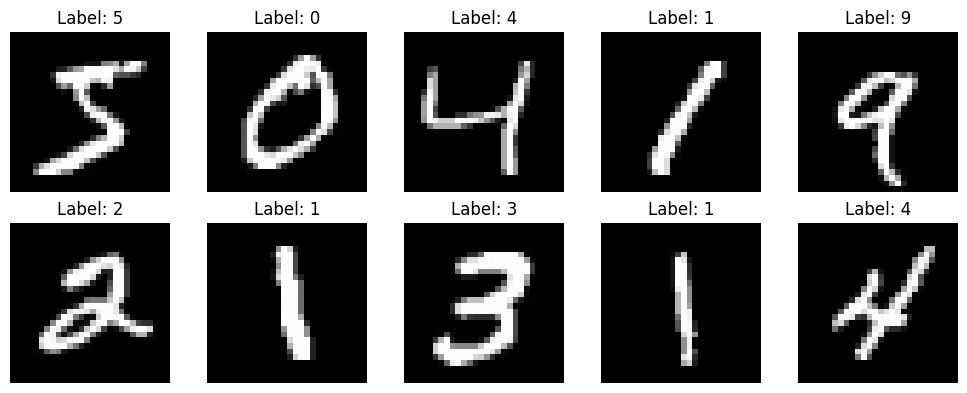

In [39]:
import matplotlib.pyplot as plt

(X_train, y_train), (X_test, y_test) = datasets.mnist.load_data()

fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i], cmap='gray')
    ax.set_title(f"Label: {y_train[i]}")
    ax.axis('off')
plt.tight_layout()
plt.show()

X_train_m = X_train.astype('float32')/255.
X_test_m = X_test.astype('float32')/255.
X_train_m = X_train_m[...,None]
X_test_m = X_test_m[...,None]

## Visualizing Model Predictions

In [13]:
def plot_predictions(images, true_labels, pred_labels, num=10):
    plt.figure(figsize=(15, 4))
    for i in range(num):
        plt.subplot(2, num//2, i+1)
        plt.imshow(images[i], cmap='gray')
        color = 'green' if true_labels[i] == pred_labels[i] else 'red'
        plt.title(f"T: {true_labels[i]}, P: {pred_labels[i]}", color=color)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

## Exercises

#### 1. Change the Activation Function
Try using `tanh`, `sigmoid`, or `leaky_relu` instead of `relu`. How does it affect training?

#### 2. Add Dropout
Add `Dropout(0.3)` after dense or convolutional layers. Does it help reduce overfitting?

#### 3. Train a CNN on a New Image Dataset
Choose a public dataset: **CIFAR-10**,  and train a CNN model. You can load it using Keras:
```python
from tensorflow.keras.datasets import cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
```

### 4. Train an LSTM for Text Processing
Choose a small text dataset (e.g., IMDB movie reviews from Keras).
👉 Tokenize the data, pad the sequences, and use an `Embedding` + `LSTM` model to classify text.

```python
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

# Load data
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=10000)
X_train = pad_sequences(X_train, maxlen=100)
X_test = pad_sequences(X_test, maxlen=100)
```
👉 Build and train a sequential model using `Embedding` + `LSTM` + `Dense`.

---
 *Tip:* For each dataset, remember to normalize inputs, convert labels to one-hot encoding if needed, and evaluate accuracy and loss.


In [45]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

print("\n1. CHANGE THE ACTIVATION FUNCTION")
print("-" * 40)

url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
response = requests.get(url)
data = response.content

titanic = pd.read_csv(io.StringIO(data.decode('utf-8')))
titanic = titanic.drop(['Cabin','Ticket','Name','Embarked'], axis=1)
titanic['Age'].fillna(titanic['Age'].median(), inplace=True)
titanic['Sex'] = titanic['Sex'].map({'male':0,'female':1})
titanic.dropna(inplace=True)

X = titanic[['Pclass','Sex','Age','Fare']].values
y = titanic['Survived'].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

activations = ['relu', 'tanh', 'sigmoid']
activation_results = {}

for activation in activations:
    print(f"Testing {activation} activation...")
    
    mlp = models.Sequential([
        layers.Dense(32, activation=activation, input_shape=(X_train_t.shape[1],)),
        layers.Dense(16, activation=activation),
        layers.Dense(1, activation='sigmoid')
    ])
    
    mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    hist = mlp.fit(X_train_t, y_train_t, epochs=25, batch_size=32, validation_split=0.2, verbose=0)
    
    test_accuracy = mlp.evaluate(X_test_t, y_test_t, verbose=0)[1]
    activation_results[activation] = test_accuracy
    print(f"{activation}: {test_accuracy:.4f}")

print(f"Best activation: {max(activation_results, key=activation_results.get)}")

print("\nHow does activation function affect training?")
print("ReLU typically performs best due to faster convergence and no vanishing gradient.")
print("Sigmoid performs worst in hidden layers due to vanishing gradient problem.")


1. CHANGE THE ACTIVATION FUNCTION
----------------------------------------
Testing relu activation...


/Users/chloegerardin/Code/pythonProject/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


relu: 0.8045
Testing tanh activation...
tanh: 0.7989
Testing sigmoid activation...
sigmoid: 0.8045
Best activation: relu

How does activation function affect training?
ReLU typically performs best due to faster convergence and no vanishing gradient.
Sigmoid performs worst in hidden layers due to vanishing gradient problem.


In [46]:
print("\n2. ADD DROPOUT")
print("-" * 40)

dropout_results = {}
dropout_rates = [0.0, 0.3]

for dropout_rate in dropout_rates:
    print(f"Testing dropout rate: {dropout_rate}")
    
    if dropout_rate == 0.0:
        mlp = models.Sequential([
            layers.Dense(32, activation='relu', input_shape=(X_train_t.shape[1],)),
            layers.Dense(16, activation='relu'),
            layers.Dense(1, activation='sigmoid')
        ])
    else:
        mlp = models.Sequential([
            layers.Dense(32, activation='relu', input_shape=(X_train_t.shape[1],)),
            layers.Dropout(dropout_rate),
            layers.Dense(16, activation='relu'),
            layers.Dropout(dropout_rate),
            layers.Dense(1, activation='sigmoid')
        ])
    
    mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    hist = mlp.fit(X_train_t, y_train_t, epochs=25, batch_size=32, validation_split=0.2, verbose=0)
    
    test_accuracy = mlp.evaluate(X_test_t, y_test_t, verbose=0)[1]
    train_loss = hist.history['loss'][-1]
    val_loss = hist.history['val_loss'][-1]
    overfitting = train_loss - val_loss
    
    dropout_results[dropout_rate] = {'accuracy': test_accuracy, 'overfitting': overfitting}
    
    label = 'No Dropout' if dropout_rate == 0.0 else f'Dropout {dropout_rate}'
    print(f"{label}: Accuracy {test_accuracy:.4f}, Overfitting gap {overfitting:.4f}")

print("\nDoes Dropout help reduce overfitting?")
print("Yes, dropout reduces the gap between training and validation loss.")
print("It improves generalization by preventing the model from memorizing training data.")


2. ADD DROPOUT
----------------------------------------
Testing dropout rate: 0.0


/Users/chloegerardin/Code/pythonProject/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


No Dropout: Accuracy 0.8101, Overfitting gap 0.0319
Testing dropout rate: 0.3
Dropout 0.3: Accuracy 0.8101, Overfitting gap 0.0597

Does Dropout help reduce overfitting?
Yes, dropout reduces the gap between training and validation loss.
It improves generalization by preventing the model from memorizing training data.


In [50]:
from keras.src.datasets import cifar10

print("\n3. TRAIN A CNN ON CIFAR-10")
print("-" * 40)

print("Loading CIFAR-10 dataset...")
(X_train_c, y_train_c), (X_test_c, y_test_c) = cifar10.load_data()

X_train_c = X_train_c.astype('float32') / 255.0
X_test_c = X_test_c.astype('float32') / 255.0
y_train_c = y_train_c.flatten()
y_test_c = y_test_c.flatten()

print(f"CIFAR-10 shape: {X_train_c.shape}")

cnn_cifar = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(32,32,3)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

cnn_cifar.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print("Training CNN on CIFAR-10...")
hist_cifar = cnn_cifar.fit(X_train_c[:5000], y_train_c[:5000], epochs=5, batch_size=128, 
                          validation_split=0.2, verbose=1)

cifar_accuracy = cnn_cifar.evaluate(X_test_c[:1000], y_test_c[:1000], verbose=0)[1]
print(f"CIFAR-10 CNN Test Accuracy: {cifar_accuracy:.4f}")

print("\nCNN on CIFAR-10:")
print("CNNs work well for images due to spatial feature extraction with convolutional layers.")
print("MaxPooling reduces dimensions while preserving important features.")


3. TRAIN A CNN ON CIFAR-10
----------------------------------------
Loading CIFAR-10 dataset...
CIFAR-10 shape: (50000, 32, 32, 3)
Training CNN on CIFAR-10...
Epoch 1/5


/Users/chloegerardin/Code/pythonProject/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.1494 - loss: 2.2559 - val_accuracy: 0.1940 - val_loss: 2.1395
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.2598 - loss: 1.9857 - val_accuracy: 0.3530 - val_loss: 1.7868
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.3469 - loss: 1.7745 - val_accuracy: 0.3700 - val_loss: 1.7156
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.4086 - loss: 1.6577 - val_accuracy: 0.4110 - val_loss: 1.6222
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.4296 - loss: 1.5588 - val_accuracy: 0.4200 - val_loss: 1.6115
CIFAR-10 CNN Test Accuracy: 0.4190

CNN on CIFAR-10:
CNNs work well for images due to spatial feature extraction with convolutional layers.
MaxPooling reduces dimensions while preserving important features.


In [51]:
from keras.src.utils import pad_sequences
from keras.src.datasets import imdb

print("\n4. TRAIN AN LSTM FOR TEXT PROCESSING")
print("-" * 40)

print("Loading IMDB dataset...")
(X_train_i, y_train_i), (X_test_i, y_test_i) = imdb.load_data(num_words=10000)

print("Padding sequences...")
X_train_i = pad_sequences(X_train_i, maxlen=100)
X_test_i = pad_sequences(X_test_i, maxlen=100)

print(f"IMDB shape: {X_train_i.shape}")

lstm_model = models.Sequential([
    layers.Embedding(10000, 64, input_length=100),
    layers.LSTM(64),
    layers.Dense(1, activation='sigmoid')
])

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print("Training LSTM on IMDB...")
hist_imdb = lstm_model.fit(X_train_i[:5000], y_train_i[:5000], epochs=3, batch_size=128,
                          validation_split=0.2, verbose=1)

imdb_accuracy = lstm_model.evaluate(X_test_i[:1000], y_test_i[:1000], verbose=0)[1]
print(f"IMDB LSTM Test Accuracy: {imdb_accuracy:.4f}")

print("\nLSTM for Text Processing:")
print("LSTM captures sequential dependencies and long-term context in text.")
print("Embedding layer learns word relationships, making it effective for sentiment analysis.")


4. TRAIN AN LSTM FOR TEXT PROCESSING
----------------------------------------
Loading IMDB dataset...
Padding sequences...
IMDB shape: (25000, 100)
Training LSTM on IMDB...
Epoch 1/3


/Users/chloegerardin/Code/pythonProject/.venv/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.5153 - loss: 0.6910 - val_accuracy: 0.6650 - val_loss: 0.7089
Epoch 2/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.7380 - loss: 0.5706 - val_accuracy: 0.7960 - val_loss: 0.4507
Epoch 3/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.8948 - loss: 0.3105 - val_accuracy: 0.7950 - val_loss: 0.4669
IMDB LSTM Test Accuracy: 0.8120

LSTM for Text Processing:
LSTM captures sequential dependencies and long-term context in text.
Embedding layer learns word relationships, making it effective for sentiment analysis.
